# Enmarcar el problema y tener una vista amplia

### 1. Objetivo en términos de negocio

Reducir los costos y penalizaciones asociados a concentrados con alto contenido de sílice, entregando a los operadores alertas predictivas 30-60 min antes de que el análisis de laboratorio confirme un sobre-límite.

### 2. ¿Cómo se usará la solución?	

Como un servicio en línea integrado a la sala de control: cada minuto calcula un pronóstico de % Sílice para los próximos 30-60 min. Si el valor proyectado supera un umbral operativo (p.ej. 1,5 %), dispara una advertencia y una recomendación de ajuste (dosificación de reactivos, flujo de aire, pH, etc.).

### 3. Soluciones actuales / workarounds	

* Esperar el resultado de laboratorio (∼60 min de rezago) y ajustar reactivos “a ciegas”.

* Heurísticas basadas en experiencia de los operadores.

### 4. Enfoque del problema	

Aprendizaje supervisado de serie temporal (regresión).

### 5. Cómo medir el desempeño	

Métricas primarias:

• MAPE (objetivo < 8 %)

• RMSE (para comparar con la variabilidad histórica)

Métrica secundaria: 

recall de eventos “críticos” (> 1,8 % Sílice).


Un error porcentual bajo y un alto recall en eventos críticos reducen directamente multas y relaves.

### 6. Desempeño mínimo aceptable	

MAPE ≤ 10 % y capacidad de detectar ≥ 90 % de los eventos donde % Sílice > 1,8 %.

### 7. Solución manual hipotética

Muestrear cada 20 s variables clave y aplicar reglas fijas (“si pH < 10 y ORP > 550 → aumentar 5 % de almidón”). Ineficiente y sensible al ruido.

### 8. Supuestos realizados	

* Las 23 variables de proceso influyen causalmente en el % Sílice.
* El retardo entre variables de proceso y análisis de laboratorio es constante (≈ 60 min).
* Los datos de marzo-septiembre 2017 son representativos de las condiciones actuales.

# Proyecto Intro a la IA

In [80]:
import pandas as pd
df = pd.read_csv('MiningProcess_Flotation_Plant_Database.csv')

#-- parseo de fechas y orden cronológico
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

In [81]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,"55,2","16,98","3019,53","557,434","395,713","10,0664","1,74","249,214","253,235","250,576",...,"250,884","457,396","432,962","424,954","443,558","502,255","446,37","523,344","66,91","1,31"
2017-03-10 01:00:00,"55,2","16,98","3185,55","586,182","404,648","10,1139","1,73614","250,488","250,488","249,214",...,"248,95","450,139","510,332","461,638","422,888","451,528","510,098","513,904","66,91","1,31"
2017-03-10 01:00:00,"55,2","16,98","3182,03","595,947","407,168","10,1135","1,73545","250,62","252,334","249,39",...,"251,499","440,53","518,6","465,414","405,704","433,686","513,794","512,252","66,91","1,31"
2017-03-10 01:00:00,"55,2","16,98","3180,86","600,464","402,598","10,113","1,73476","250,576","250,62","249,258",...,"250,269","443,833","510,446","456,246","415,706","428,618","481,874","468,224","66,91","1,31"
2017-03-10 01:00:00,"55,2","16,98","1272,66","594,971","393,516","10,1125","1,73407","250,488","249,302","249,302",...,"248,511","453,242","502,968","451,604","441,878","427,296","433,372","412,824","66,91","1,31"


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737453 entries, 2017-03-10 01:00:00 to 2017-09-09 23:00:00
Data columns (total 23 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   % Iron Feed                   737453 non-null  object
 1   % Silica Feed                 737453 non-null  object
 2   Starch Flow                   737453 non-null  object
 3   Amina Flow                    737453 non-null  object
 4   Ore Pulp Flow                 737453 non-null  object
 5   Ore Pulp pH                   737453 non-null  object
 6   Ore Pulp Density              737453 non-null  object
 7   Flotation Column 01 Air Flow  737453 non-null  object
 8   Flotation Column 02 Air Flow  737453 non-null  object
 9   Flotation Column 03 Air Flow  737453 non-null  object
 10  Flotation Column 04 Air Flow  737453 non-null  object
 11  Flotation Column 05 Air Flow  737453 non-null  object
 12  Flotation Column 06 Air 

In [83]:
df.describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,737453,737453,737453,737453,737453,737453,737453,737453,737453,737453,...,737453,737453,737453,737453,737453,737453,737453,737453,737453,737453
unique,278,293,409317,319416,180189,131143,105805,43675,80442,40630,...,86819,299573,331189,322315,309264,276051,301502,295667,38696,55569
top,"64,03","6,26","2562,5","534,668","402,246","10,0591","1,75","299,927","255,322","298,828",...,"299,487","452,441","608,887","601,06","491,406","513,879","474,37","479,478","65,44","2,08"
freq,142560,142560,690,959,1735,1509,3214,13683,1487,6012,...,3405,1013,817,989,733,709,746,905,16920,17100


In [84]:
import pandas as pd
PATH = "MiningProcess_Flotation_Plant_Database.csv"

# 1) Cargar —> parsear fecha
df = (pd.read_csv(PATH, parse_dates=['date'])
        .sort_values('date')
        .set_index('date'))

# 2) Cambiar coma decimal: punto y pasar a float
num_cols = df.columns # todas las columnas son numéricas                  
df[num_cols] = (df[num_cols]
                  .apply(lambda s: s.str.replace(',', '.', regex=False))
                  .apply(pd.to_numeric, errors='coerce'))

# 3) Sanity-check
print(df.dtypes.unique())   # → float64
print(df.isna().mean().round(3).head())

[dtype('float64')]
% Iron Feed      0.0
% Silica Feed    0.0
Starch Flow      0.0
Amina Flow       0.0
Ore Pulp Flow    0.0
dtype: float64


In [85]:
df.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74000,249.214,253.235,250.576,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3185.55,586.182,404.648,10.1139,1.73614,250.488,250.488,249.214,...,248.950,450.139,510.332,461.638,422.888,451.528,510.098,513.904,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3182.03,595.947,407.168,10.1135,1.73545,250.620,252.334,249.390,...,251.499,440.530,518.600,465.414,405.704,433.686,513.794,512.252,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,3180.86,600.464,402.598,10.1130,1.73476,250.576,250.620,249.258,...,250.269,443.833,510.446,456.246,415.706,428.618,481.874,468.224,66.91,1.31
2017-03-10 01:00:00,55.2,16.98,1272.66,594.971,393.516,10.1125,1.73407,250.488,249.302,249.302,...,248.511,453.242,502.968,451.604,441.878,427.296,433.372,412.824,66.91,1.31


In [86]:
# Resamplear a 1 hora, interpolar y eliminar NaN
# qué es interpolar? : Interpolar
df_h = (df.resample('1H').mean()
          .interpolate(limit=2)
          .dropna(subset=['% Silica Concentrate'])) # target variable

C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\1438705981.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_h = (df.resample('1H').mean()


In [87]:
df_h.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
date,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,55.2,16.98,3162.625026,578.786678,398.753368,10.113487,1.729558,251.166672,250.226086,250.178287,...,250.208184,450.383776,446.891845,450.474523,449.912259,455.792161,464.383310,450.532747,66.91,1.31
2017-03-10 02:00:00,55.2,16.98,3133.256389,537.219661,399.871822,10.129742,1.667784,249.880589,250.214050,250.033317,...,249.897572,449.373361,450.249356,450.081222,450.328806,448.722983,455.501528,451.387700,67.06,1.11
2017-03-10 03:00:00,55.2,16.98,3479.482944,591.906744,398.763806,10.048403,1.732711,250.161328,250.104167,250.046350,...,250.484183,449.972878,450.868711,450.901822,451.145822,451.134189,459.981311,450.296722,66.97,1.27
2017-03-10 04:00:00,55.2,16.98,3228.036436,593.170106,399.866983,9.918614,1.731056,250.208772,250.204761,250.120861,...,250.157622,487.940706,491.462111,487.387206,494.528183,495.664011,502.763850,494.939889,66.75,1.36
2017-03-10 05:00:00,55.2,16.98,3327.280739,619.710806,399.615089,9.746029,1.765879,249.917800,250.160494,250.013500,...,250.078639,549.031539,549.983156,549.459572,549.975483,549.512533,560.696300,550.271772,66.63,1.34


In [88]:
df_h.describe()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,...,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000,4099.000000
mean,56.295300,14.650894,2869.480845,488.076261,397.580158,9.767389,1.680340,280.136760,277.146208,281.066819,...,290.734620,520.273361,522.682288,531.366663,420.357549,425.284561,429.975413,421.057204,65.049592,2.327457
std,5.157152,6.806680,950.371891,83.727885,8.369025,0.378108,0.063785,29.410521,29.422505,28.375023,...,27.228171,122.152853,116.036433,138.555834,76.584486,75.029328,75.504588,72.555578,1.118049,1.124959
min,42.740000,1.310000,54.595483,242.927477,376.837604,8.753389,1.519926,175.885579,178.188430,177.202665,...,199.728122,181.925623,224.909663,135.214506,165.725058,214.735894,203.702926,185.061388,62.050000,0.600000
25%,52.670000,8.940000,2169.112608,435.936571,398.852597,9.540432,1.651137,250.089650,250.096500,250.087175,...,282.413703,416.503592,449.250192,405.432300,351.492808,350.982311,354.149592,350.942239,64.360000,1.440000
50%,56.080000,13.850000,2908.578878,502.361032,399.844044,9.795729,1.695703,299.837544,299.526394,299.887856,...,299.861000,499.621444,499.826461,499.594994,401.286361,401.127850,407.679350,400.991200,65.210000,2.000000
75%,59.720000,19.590000,3529.370972,549.521517,400.590786,10.030750,1.721788,299.951350,299.979728,299.946533,...,300.112333,599.711403,599.331081,600.213564,496.113150,497.749469,497.906617,462.532917,65.860000,3.010000
max,65.780000,33.400000,6270.158798,736.982378,418.070232,10.807370,1.832430,312.295415,309.887767,302.783000,...,351.268656,859.025062,827.775874,884.840698,675.631942,674.068176,698.505832,655.501603,68.010000,5.530000


In [89]:
# Eliminar % Iron Concentrate porque es otro target
df_h = df_h.drop(columns=['% Iron Concentrate'])

## Análisis Exploratorio de Datos (EDA)

### Cargamos los Datos y Ajustamos

In [90]:
import pandas as pd
PATH = "MiningProcess_Flotation_Plant_Database.csv"

# 1) Cargar —> parsear fecha
df = (pd.read_csv(PATH, parse_dates=['date'])
        .sort_values('date')
        .set_index('date'))

# 2) Cambiar coma decimal: punto y pasar a float
num_cols = df.columns # todas las columnas son numéricas                  
df[num_cols] = (df[num_cols]
                  .apply(lambda s: s.str.replace(',', '.', regex=False))
                  .apply(pd.to_numeric, errors='coerce'))

# 3) Sanity-check
print(df.dtypes.unique())   # → float64
print(df.isna().mean().round(3).head())

[dtype('float64')]
% Iron Feed      0.0
% Silica Feed    0.0
Starch Flow      0.0
Amina Flow       0.0
Ore Pulp Flow    0.0
dtype: float64


In [91]:
# Eliminar % Iron Concentrate porque es otro target
df= df.drop(columns=['% Iron Concentrate'])

### Nulos, Varianza y Duplicados

In [92]:
import numpy as np

# % de nulos por columna
null_rate = df.isna().mean().sort_values(ascending=False)

# varianza (detecta columnas constantes / casi constantes)
var = df.var()

# filas duplicadas por timestamp (mismo índice y misma fila):
dupes_exact = df[df.duplicated(keep=False)]

# produce un reporte compacto
quality = pd.DataFrame({
    'null_%': (null_rate*100).round(2),
    'variance': var.round(6)
}).sort_values('null_%', ascending=False)

quality.head(25)

,null_%,variance
% Iron Feed,0.0,2.660233e+01
% Silica Concentrate,0.0,1.266871e+00
Ore Pulp pH,0.0,1.497750e-01
Ore Pulp Flow,0.0,9.408583e+01
Ore Pulp Density,0.0,4.795000e-03
Flotation Column 07 Level,0.0,7.206565e+03
Flotation Column 07 Air Flow,0.0,8.219749e+02
Flotation Column 06 Level,0.0,8.075220e+03
Flotation Column 06 Air Flow,0.0,9.131157e+02
Flotation Column 05 Level,0.0,7.146305e+03


### Distribución de Nulos

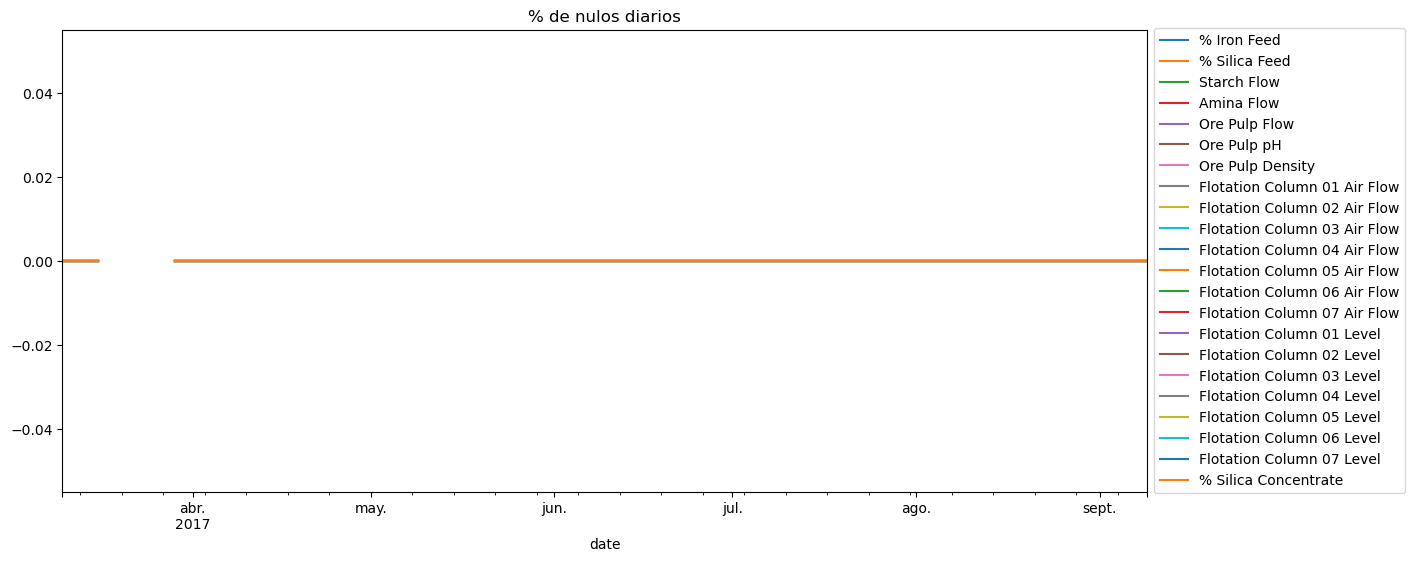

In [93]:
# nulos por día
nulos_dia = df.isna().resample('1D').mean()*100
nulos_dia.plot(figsize=(14,6), title='% de nulos diarios');   # rápido vistazo
# colocar leyenda sin molestar en el gráfico
import matplotlib.pyplot as plt
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)


In [94]:
'''
Se puede observar que faltana valores en las fechas entre el 2017-03-16 08:00:00 y 2017-03-29 11:00:00

'''

'\nSe puede observar que faltana valores en las fechas entre el 2017-03-16 08:00:00 y 2017-03-29 11:00:00\n\n'

In [95]:
# df_hourly = dataframe ya colapsado a 1 h (sin duplicados)

df_hourly = df.resample('1H').mean().interpolate(limit=2).dropna(subset=['% Silica Concentrate'])
import pandas as pd, numpy as np

full_idx   = pd.date_range(df_hourly.index.min(),
                           df_hourly.index.max(),
                           freq='1H')
missing_ts = full_idx.difference(df_hourly.index)

print(f"Horas esperadas : {len(full_idx):,}")
print(f"Horas presentes : {len(df_hourly):,}")
print(f"Horas faltantes : {len(missing_ts):,}")   # debería ser 0


C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\3862510235.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('1H').mean().interpolate(limit=2).dropna(subset=['% Silica Concentrate'])


Horas esperadas : 4,415
Horas presentes : 4,099
Horas faltantes : 316


C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\3862510235.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx   = pd.date_range(df_hourly.index.min(),


In [96]:
# --- localizar bloques de huecos ---
missing = pd.Series(1, index=missing_ts)
# agrupa por continuidad
gaps = (missing.index.to_series().diff() != pd.Timedelta('1H')).cumsum()
gap_info = missing.groupby(gaps).size().sort_values(ascending=False)

print(gap_info.head())


1    316
dtype: int64


C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\588522450.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  gaps = (missing.index.to_series().diff() != pd.Timedelta('1H')).cumsum()


In [97]:
'''
Como es un bloque de huecos continuo y largo, aproximadamente 7% del periodo total, imputarlo no sería una buena idea, ya que introduciría un sesgo importante en el modelo.
Por lo tanto, eliminaremos este bloque de huecos.
'''

'\nComo es un bloque de huecos continuo y largo, aproximadamente 7% del periodo total, imputarlo no sería una buena idea, ya que introduciría un sesgo importante en el modelo.\nPor lo tanto, eliminaremos este bloque de huecos.\n'

In [98]:
# reconstruir índice completo y hallar horas faltantes 
full_idx   = pd.date_range(df.index.min(), df.index.max(), freq='1H')
missing_ts = full_idx.difference(df.index)

# agrupar huecos contiguos 
missing      = pd.Series(1, index=missing_ts)
gaps         = (missing.index.to_series().diff() != pd.Timedelta('1H')).cumsum()
gap_df = missing.groupby(gaps).apply(
    lambda x: pd.Series({
        'start': x.index.min(),
        'end': x.index.max(),
        'hours': len(x)
    })
).reset_index(drop=True)

print(gap_df)



0    2017-03-16 06:00:00
1    2017-03-29 11:00:00
2                    318
dtype: object


C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\669468118.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx   = pd.date_range(df.index.min(), df.index.max(), freq='1H')
C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\669468118.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  gaps         = (missing.index.to_series().diff() != pd.Timedelta('1H')).cumsum()


In [99]:
gap_start = pd.Timestamp('2017-03-16 06:00')
gap_end   = pd.Timestamp('2017-03-29 11:00')

# dataframe horario ya colapsado a 1 h:
df_h = df.groupby(df.index).mean()

# corta el rango de 318 h ausentes
df_h = df_h.drop(index=df_h.loc[gap_start:gap_end].index)


In [100]:
full_idx   = pd.date_range(df_h.index.min(), df_h.index.max(), freq='1H')
missing_ts = full_idx.difference(df_h.index)

print("Horas faltantes después del corte:", len(missing_ts))  # ⇒ 0
print("Timestamps duplicados           :", df_h.index.duplicated().sum())  # ⇒ 0


Horas faltantes después del corte: 318
Timestamps duplicados           : 0


C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\3751898402.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx   = pd.date_range(df_h.index.min(), df_h.index.max(), freq='1H')


In [101]:
# df_h: dataframe horario ya sin duplicados y con el bloque faltante eliminado
cut_ini = '2017-03-29 11:00'          # inclusive
df_h = df_h.loc[cut_ini:]             # descarta todo lo anterior

# verificación final de continuidad
full_idx   = pd.date_range(df_h.index.min(), df_h.index.max(), freq='1H')
assert full_idx.difference(df_h.index).size == 0, "Aún quedan huecos"

print(f"Total de horas después del corte: {len(df_h):,}")
print("Serie horaria continua y sin gaps")


Total de horas después del corte: 3,948
Serie horaria continua y sin gaps


C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\1887348903.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx   = pd.date_range(df_h.index.min(), df_h.index.max(), freq='1H')


### Resumen Estadístico

In [102]:
vars_core = ['% Silica Concentrate', '% Silica Feed', '% Iron Feed',
             'Ore Pulp pH', 'Starch Flow', 'Amina Flow',
             'Ore Pulp Flow', 'Ore Pulp Density',
             'Flotation Column 02 Air Flow']

df_h[vars_core].describe(percentiles=[.01, .05, .95, .99]).T


,count,mean,std,min,1%,5%,50%,95%,99%,max
% Silica Concentrate,3948.0,2.322261,1.120117,0.600000,0.980000,1.090000,2.000000,4.726500,5.260109,5.530000
% Silica Feed,3948.0,14.767789,6.887711,1.310000,6.080000,6.260000,14.200000,26.882000,30.140000,33.400000
% Iron Feed,3948.0,56.220301,5.231150,42.740000,45.380000,48.070000,55.940000,64.030000,64.030000,65.780000
Ore Pulp pH,3948.0,9.769643,0.378012,8.753389,8.758807,9.056977,9.796511,10.341100,10.577022,10.807370
Starch Flow,3948.0,2847.012956,948.913479,54.595483,636.669109,1299.306603,2880.359057,4369.774106,4995.683837,6270.158798
Amina Flow,3948.0,488.720690,83.769854,242.927477,256.571501,327.722628,502.685958,600.032645,640.027414,736.982378
Ore Pulp Flow,3948.0,397.471417,8.491449,376.837604,378.193677,380.178230,399.835435,409.934924,416.827536,418.070232
Ore Pulp Density,3948.0,1.679042,0.063417,1.519926,1.520301,1.532090,1.694900,1.761085,1.786566,1.818191
Flotation Column 02 Air Flow,3948.0,278.182019,29.490104,178.188430,191.278632,220.368223,299.596767,300.446211,301.131812,309.887767


### Histogramas + boxplots

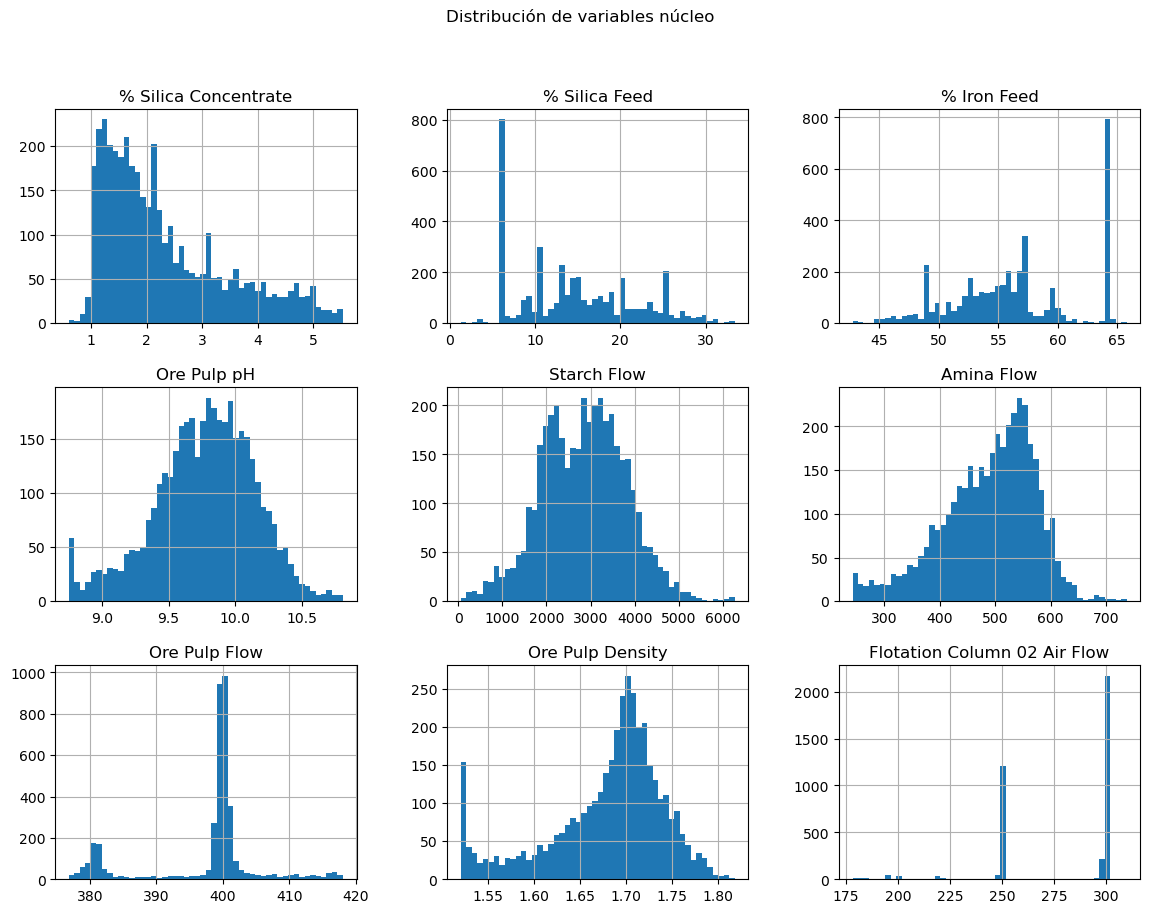

In [103]:
import matplotlib.pyplot as plt

# histos
df_h[vars_core].hist(bins=50, figsize=(14,10), layout=(3,3))
plt.suptitle("Distribución de variables núcleo"); plt.show()

Text(0.5, 0.98, 'Boxplots de variables núcleo')

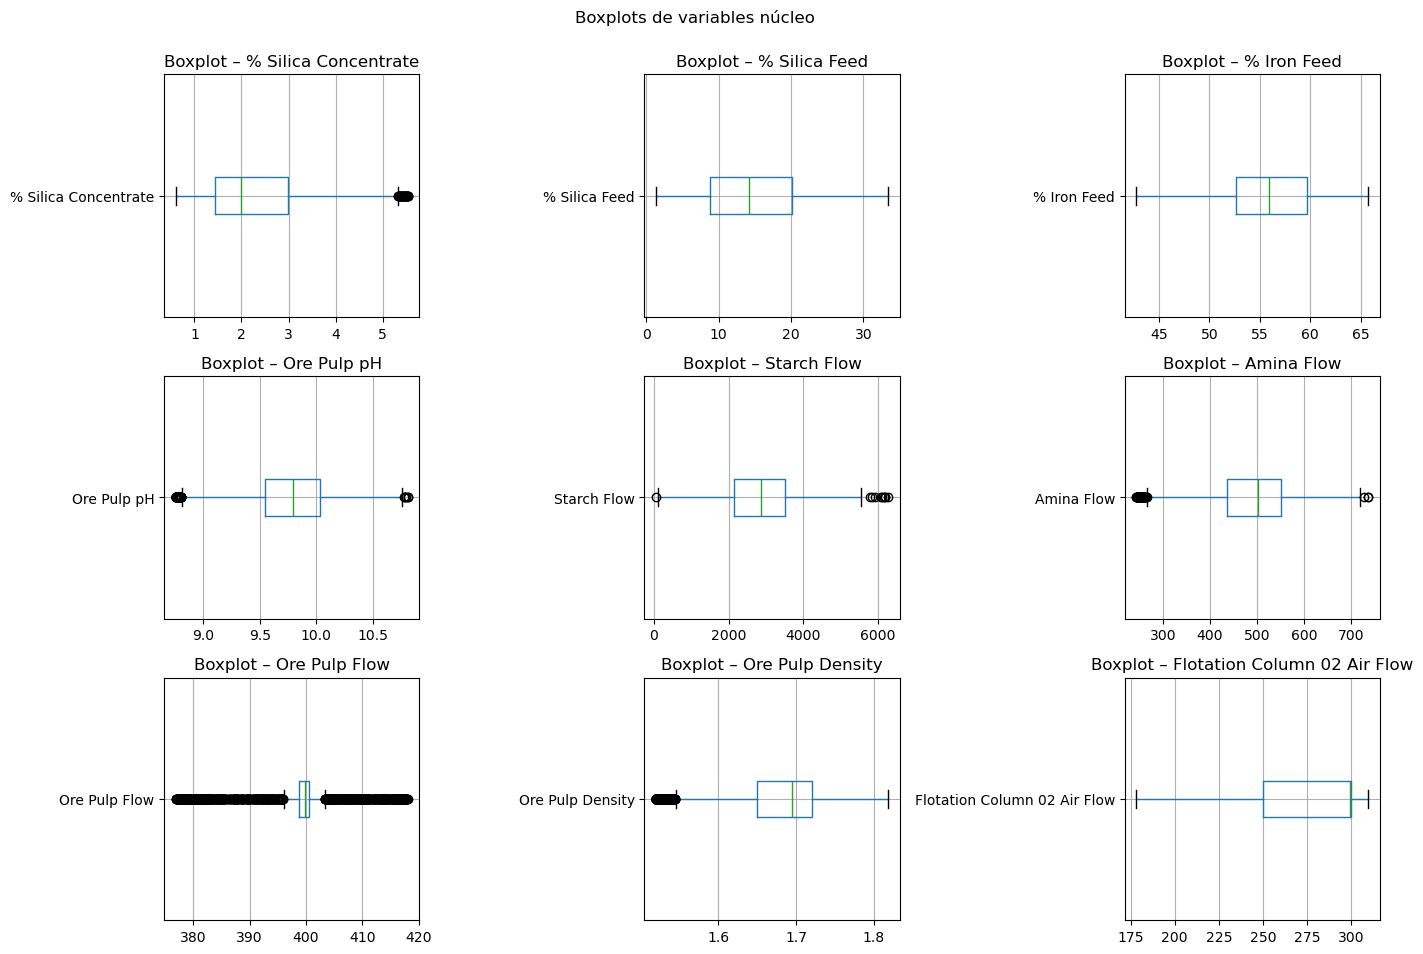

In [104]:
# Boxplots de todas las variables
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,10))
axes = axes.flatten()  # aplana la matriz de ejes
for i, v in enumerate(vars_core):
    df_h.boxplot(column=v, ax=axes[i], vert=False)
    axes[i].set_title(f"Boxplot – {v}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # ajusta el layout
plt.suptitle("Boxplots de variables núcleo")

### Series temporales & ACF

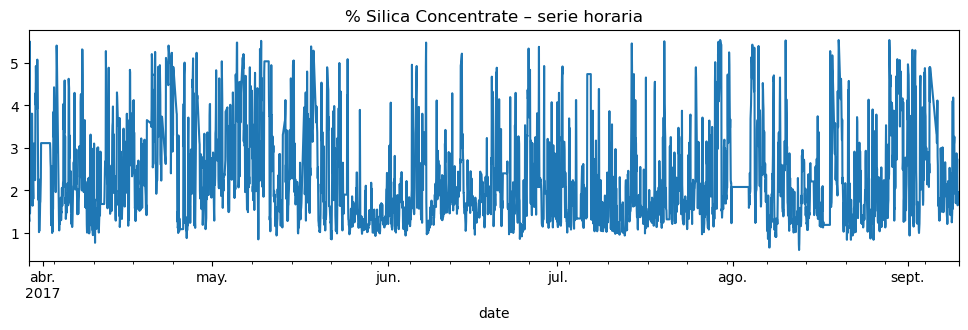

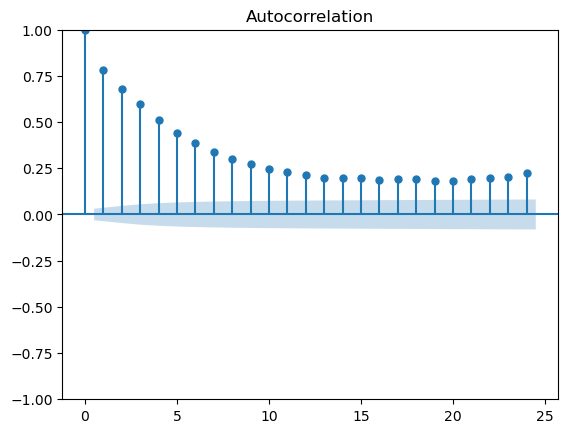

In [105]:
from statsmodels.graphics.tsaplots import plot_acf

# serie target
df_h['% Silica Concentrate'].plot(figsize=(12,3), title="% Silica Concentrate – serie horaria")

# ACF hasta 24 lags
plot_acf(df_h['% Silica Concentrate'].dropna(), lags=24)
plt.show()


### Correlación y cross-correlation

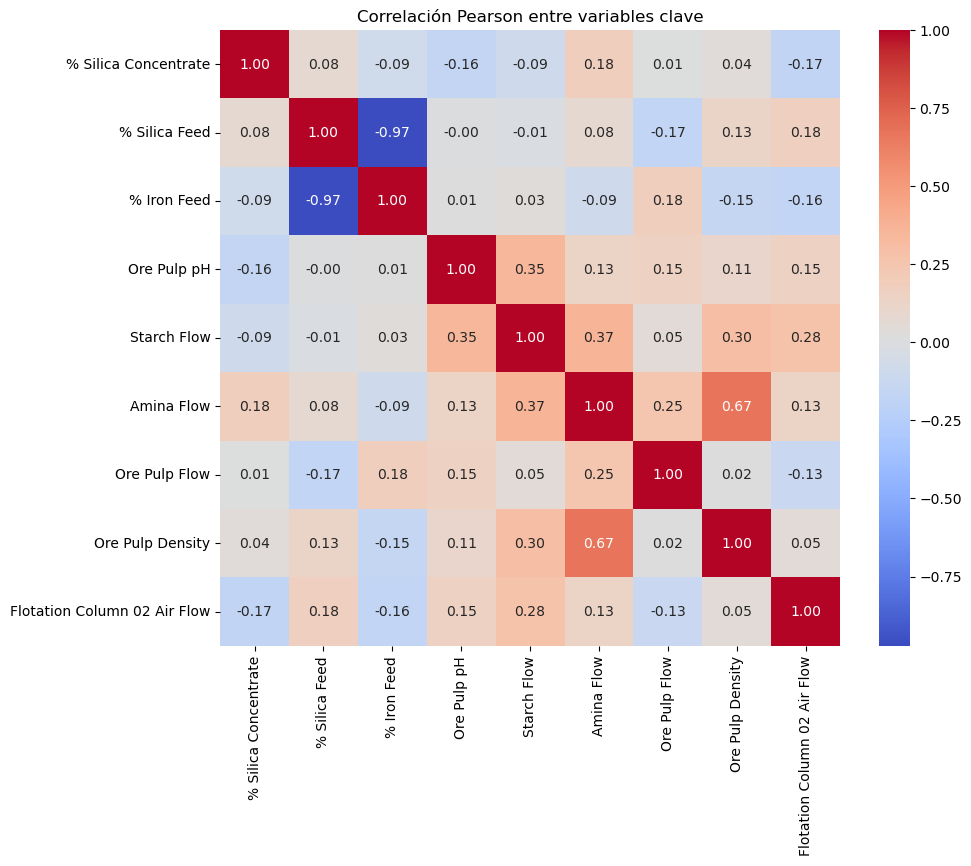

In [106]:
import seaborn as sns

# Heatmap de Pearson
plt.figure(figsize=(10,8))
corr = df_h[vars_core].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación Pearson entre variables clave"); plt.show()


C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\3710362018.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  c = [correlate(y, x.shift(k).fillna(method='bfill'), mode='valid')[0] /


Text(0.5, 0, 'Lag (h)')

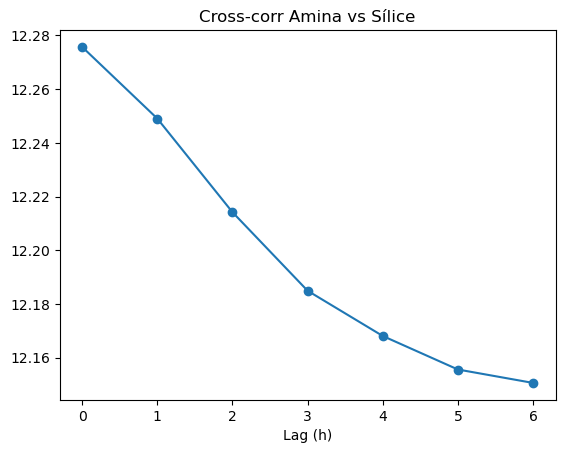

In [107]:
from scipy.signal import correlate

def crosscorr(x, y, lag=6):          # lag máximo + /- 6 h
    lags = range(-lag, lag+1)
    c = [correlate(y, x.shift(k).fillna(method='bfill'), mode='valid')[0] /
         (len(y)*y.std()*x.std()) for k in lags]
    return pd.Series(c, index=lags)

ccf_amina = crosscorr(df_h['Amina Flow'], df_h['% Silica Concentrate'])
ccf_amina.plot(marker='o', title="Cross-corr Amina vs Sílice"); plt.xlabel("Lag (h)")


In [110]:
import numpy as np

# --- thresholds manuales (puedes afinarlos) ---
thr = {
    '% Silica Concentrate': (0.6, 5.5),
    '% Silica Feed'      : (1.3, 33.4),
    '% Iron Feed'        : (42.7, 65.8),
    'Ore Pulp pH'        : (8.75, 10.80),
    'Starch Flow'        : (50,  6000),
    'Amina Flow'         : (240, 740),
    'Ore Pulp Flow'      : (376, 420),
    'Ore Pulp Density'   : (1.52, 1.82),
    'Flotation Column 02 Air Flow': (175, 310),
}

for col, (low, high) in thr.items():
    mask = (df_h[col] < low) | (df_h[col] > high)
    df_h.loc[mask, col] = np.nan

# --- interpolación ligera ---
df_h = (df_h
        .interpolate(limit=2)                 # rellena huecos ≤ 2 h
        .fillna(method='bfill', limit=2)      # rellena huecos restantes de ≤ 2 h
        .fillna(method='ffill', limit=2))


# cuántos nulos por columna
nulls = df_h.isna().sum().sort_values(ascending=False)
print(nulls[nulls > 0])

# si quieres ver un ejemplo del hueco más grande:
col = nulls.idxmax()
na_runs = df_h[col].isna().astype(int).groupby(df_h[col].notna().cumsum()).sum()
print(f"Hueco máximo en {col}: {na_runs.max()} h")

df_h['Ore Pulp Density'] = (df_h['Ore Pulp Density']
                              .interpolate(limit=12)     # rellena hasta 12 h seguidas
                              .fillna(method='bfill', limit=12)
                              .fillna(method='ffill', limit=12))


Series([], dtype: int64)
Hueco máximo en % Iron Feed: 0 h


C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\1649183928.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill', limit=2)      # rellena huecos restantes de ≤ 2 h
C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\1649183928.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill', limit=2))
C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\1649183928.py:38: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill', limit=12)
C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\1649183928.py:39: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill', limit=12))


In [111]:
assert df_h.isna().sum().max() == 0, "Aún quedan NaN"
print("Todos los NaN resueltos")

Todos los NaN resueltos


## Feature Engineering

### Lags y rollings

In [112]:
lags   = [1, 2, 3]     # horas
rolls  = [3, 6]        # horas

def make_feats(df, cols):
    out = df.copy()
    for col in cols:
        for l in lags:
            out[f'{col}_lag{l}h'] = out[col].shift(l)
        for w in rolls:
            out[f'{col}_roll{w}h_mean'] = out[col].rolling(w).mean()
            out[f'{col}_roll{w}h_std']  = out[col].rolling(w).std()
    return out


In [ ]:
# Variable útiles 
import numpy as np

# Crear las nuevas columnas básicas
df_h['ratio_amina_starch'] = (
    df_h['Amina Flow'] / df_h['Starch Flow'].replace(0, np.nan)   # evita división por 0
)

df_h['silicaFeed_pH'] = (
    df_h['% Silica Feed'] * df_h['Ore Pulp pH']
)

# Opcional: tratar NaN resultantes si hay Starch=0 en algún punto
df_h['ratio_amina_starch'] = (
    df_h['ratio_amina_starch']
      .interpolate(limit=2)
      .fillna(method='bfill', limit=2)
      .fillna(method='ffill', limit=2)
)

# Variables útiles
core = [
    '% Silica Feed', '% Iron Feed',
    'Ore Pulp pH', 'Starch Flow', 'Amina Flow',
    'Ore Pulp Flow', 'Ore Pulp Density',
    'Flotation Column 02 Air Flow',
    'ratio_amina_starch',           # <-- nueva
    'silicaFeed_pH'                 # <-- nueva
]

In [114]:
for l in [1, 2, 3]:
    df_h[f'silica_lag{l}h'] = df_h['% Silica Concentrate'].shift(l)
core += [f'silica_lag{l}h' for l in [1,2,3]]


In [115]:
air_cols   = [c for c in df_h.columns if "Air Flow" in c]
level_cols = [c for c in df_h.columns if "Level"    in c]
core += air_cols + level_cols


In [116]:
# --- corte: train = mar-29 al ago-31, test = sept-17 ---
train_end = '2017-08-31 23:00:00'
train_raw = df_h.loc[:train_end]
test_raw  = df_h.loc['2017-09-01':]

# --- generar features POST-split (evita fuga) ---
X_train = make_feats(train_raw, core).drop(columns=['% Silica Concentrate'])
y_train = train_raw['% Silica Concentrate']
X_test  = make_feats(test_raw,  core).drop(columns=['% Silica Concentrate'])
y_test  = test_raw['% Silica Concentrate']

# eliminar filas con NaN recientes por shift/rolling
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_test= X_test.dropna() 
y_test =y_test.loc[X_test.index]

C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\3429460565.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f'{col}_lag{l}h'] = out[col].shift(l)
C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\3429460565.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f'{col}_lag{l}h'] = out[col].shift(l)
C:\Users\OMEN\AppData\Local\Temp\ipykernel_3052\3429460565.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

In [117]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import numpy as np

num_cols = X_train.columns
pre = ColumnTransformer([('num', SimpleImputer(strategy='median'), num_cols)])

rf = RandomForestRegressor(
        n_estimators=600, max_features='sqrt',
        min_samples_leaf=2, n_jobs=-1, oob_score=True, random_state=42)

pipe = Pipeline([('pre', pre), ('rf', rf)])

tscv = TimeSeriesSplit(n_splits=4)
cv_mape = -cross_val_score(pipe, X_train, y_train,
                           cv=tscv,
                           scoring='neg_mean_absolute_percentage_error').mean()
print(f"CV MAPE: {cv_mape*100:.2f}%")

pipe.fit(X_train, y_train)

pred   = pipe.predict(X_test)
mape   = mean_absolute_percentage_error(y_test, pred)
mae    = mean_absolute_error(y_test, pred)
print(f"TEST MAPE: {mape*100:.2f}%")
print(f"TEST MAE : {mae:.3f} % Silica")


CV MAPE: 32.82%
TEST MAPE: 25.13%
TEST MAE : 0.582 % Silica
